# Deteksi Penipuan (Fraud) Kartu Kredit  
**Model:** Logistic Regression (baseline) vs XGBoost (advanced)  
**Dataset:** `creditcard.csv` (Kaggle Credit Card Fraud Detection)

Notebook ini mengikuti arahan **Modul 15**: pipeline end-to-end, komparasi minimal 2 algoritma, evaluasi untuk data imbalanced (bukan hanya akurasi), menampilkan *Confusion Matrix* + *ROC Curve* + *Feature Importance*, dan menyimpan model terbaik untuk deployment (Streamlit).


> **Catatan:** Pastikan file `creditcard.csv` berada di folder yang sama dengan notebook ini (atau ubah `DATA_PATH`).  
> Jika `xgboost` belum terpasang, jalankan instalasi di bawah (opsional).


In [60]:
# Jika menjalankan di environment yang belum punya xgboost, jalankan cell ini:
# !pip -q install xgboost


## 0) Setup & Import Library

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report,
    roc_auc_score, roc_curve,
    precision_score, recall_score, f1_score,
    average_precision_score, precision_recall_curve
)

import joblib
import warnings
warnings.filterwarnings("ignore")

# XGBoost
try:
    from xgboost import XGBClassifier
except Exception as e:
    XGBClassifier = None
    print("XGBoost belum tersedia. Install dulu: pip install xgboost")
    print("Error:", e)

RANDOM_STATE = 42


## 1) Load Dataset

In [62]:
DATA_PATH = "creditcard.csv"  # pastikan file ada di folder kerja
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
display(df.head())


Shape: (20000, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 2) Data Cleaning (Duplicates & Missing Values)
Sesuai modul, kita memastikan kualitas data sebelum modeling.
- Jika ada *duplicate rows*, kita hapus agar tidak bias.
- Jika ada *missing values*, kita laporkan dan (jika perlu) lakukan imputasi.


In [63]:
missing_total = int(df.isna().sum().sum())
dupes_total = int(df.duplicated().sum())

print("Total missing values:", missing_total)
print("Total duplicated rows:", dupes_total)

# Drop duplicates jika ada
if dupes_total > 0:
    df = df.drop_duplicates().reset_index(drop=True)
    missing_total = int(df.isna().sum().sum())
    print("Duplikat dihapus. Shape baru:", df.shape)
else:
    print("Tidak ada duplikasi. Tidak perlu drop_duplicates().")

# Catatan missing values
if missing_total == 0:
    print("Tidak ada missing values. Tidak perlu imputasi.")
else:
    # Contoh sederhana: median imputation untuk fitur numerik (opsional sesuai kebutuhan)
    print("Ada missing values. Pertimbangkan imputasi (median/mean) atau drop kolom/baris sesuai konteks dataset.")


Total missing values: 0
Total duplicated rows: 69
Duplikat dihapus. Shape baru: (19931, 31)
Tidak ada missing values. Tidak perlu imputasi.


## 3) Cek Imbalance Label
Dataset fraud biasanya sangat tidak seimbang (*imbalanced*). Karena itu evaluasi **tidak boleh hanya akurasi**; gunakan F1/ROC-AUC/PR-AUC.


Class counts (0=non-fraud, 1=fraud):


Class
0    19846
1       85
Name: count, dtype: int64


Class ratio (%):


Class
0    99.573529
1     0.426471
Name: count, dtype: float64

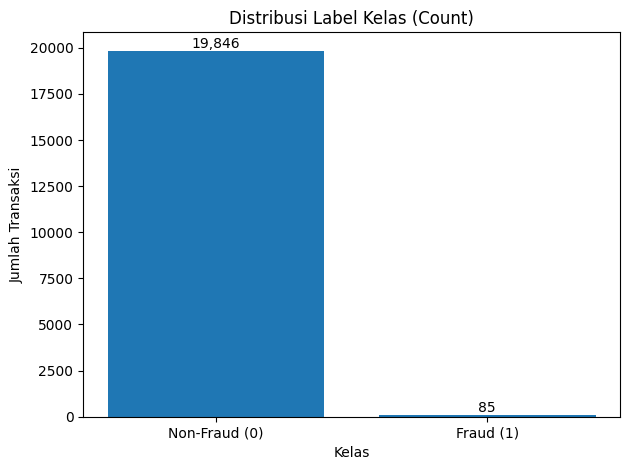

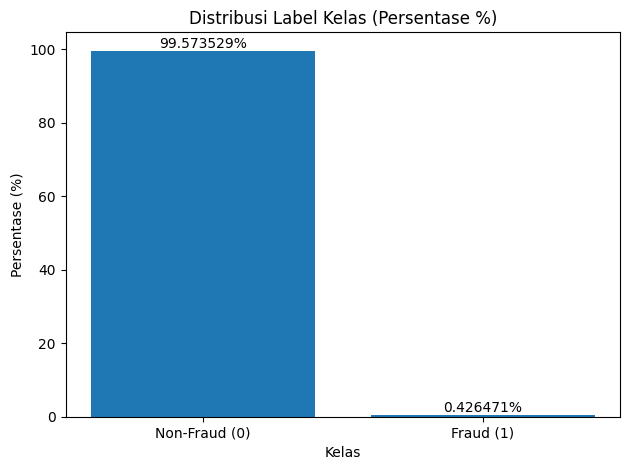

Imbalance ratio (Non-Fraud : Fraud) = 233.48 : 1


In [64]:
target_col = "Class"  # fraud=1, non-fraud=0

class_counts = df[target_col].value_counts().sort_index()
class_ratio = (class_counts / class_counts.sum() * 100).round(6)

print("Class counts (0=non-fraud, 1=fraud):")
display(class_counts)

print("\nClass ratio (%):")
display(class_ratio)

labels = ["Non-Fraud (0)", "Fraud (1)"]
counts = class_counts.values
ratios = class_ratio.values

# Bar chart count
plt.figure()
bars = plt.bar(labels, counts)
plt.title("Distribusi Label Kelas (Count)")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Transaksi")
for bar, val in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{val:,}", ha="center", va="bottom")
plt.tight_layout()
plt.show()

# Bar chart percent
plt.figure()
bars2 = plt.bar(labels, ratios)
plt.title("Distribusi Label Kelas (Persentase %)")
plt.xlabel("Kelas")
plt.ylabel("Persentase (%)")
for bar, val in zip(bars2, ratios):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{val:.6f}%", ha="center", va="bottom")
plt.tight_layout()
plt.show()

# Imbalance ratio
if counts[1] > 0:
    imbalance_ratio = counts[0] / counts[1]
    print(f"Imbalance ratio (Non-Fraud : Fraud) = {imbalance_ratio:.2f} : 1")
else:
    print("Tidak ada sampel Fraud (Class=1) di dataset ini.")


## 3) EDA Singkat (Distribusi Fitur Utama)

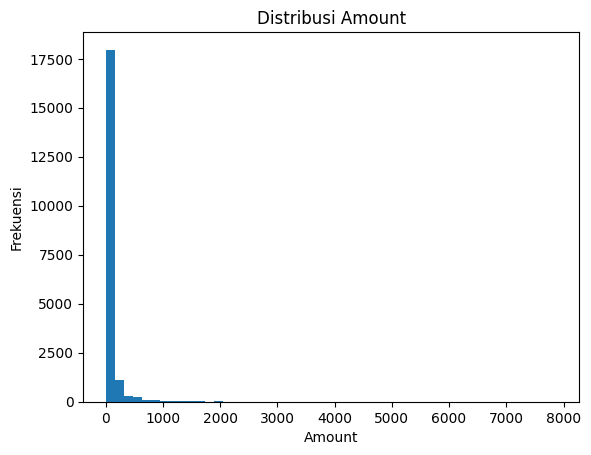

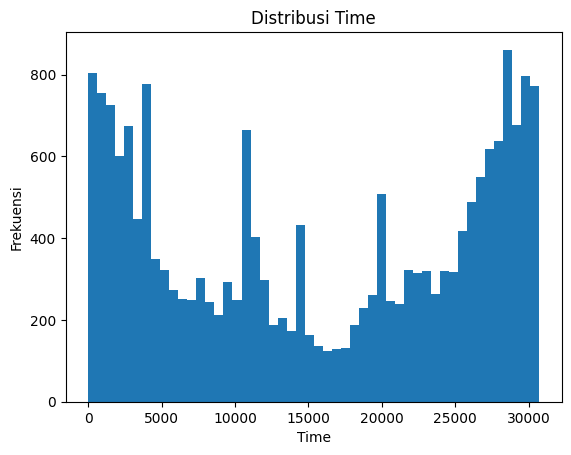

In [65]:
plt.figure()
plt.hist(df["Amount"], bins=50)
plt.title("Distribusi Amount")
plt.xlabel("Amount")
plt.ylabel("Frekuensi")
plt.show()

plt.figure()
plt.hist(df["Time"], bins=50)
plt.title("Distribusi Time")
plt.xlabel("Time")
plt.ylabel("Frekuensi")
plt.show()


## 4) Split Feature/Target

In [66]:
X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

print("X shape:", X.shape)
print("y positive rate (fraud=1):", float(y.mean()))


X shape: (19931, 30)
y positive rate (fraud=1): 0.004264713260749586


## 5) Preprocessing (Scaling untuk kolom tertentu)

- Dataset ini berisi fitur `V1..V28` (hasil PCA) + `Time` + `Amount`.
- Umumnya `Amount` (dan opsional `Time`) perlu scaling; fitur PCA sudah relatif terstandardisasi.
- Karena **Logistic Regression** sensitif terhadap skala, scaling dibutuhkan. Untuk **XGBoost**, scaling tidak wajib, tetapi kita tetap pakai preprocessing yang konsisten lewat pipeline.

> Jika ingin, kamu bisa scaling `Time` juga (misalnya `scale_cols = ["Amount", "Time"]`).


In [67]:
# Pilih kolom yang akan di-scaling.
scale_cols = ["Amount"]
passthrough_cols = [c for c in X.columns if c not in scale_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("scale", RobustScaler(), scale_cols),
        ("pass", "passthrough", passthrough_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)


## 6) Train/Validation/Test Split (Stratified)

Agar **threshold tuning** tidak bias, kita bagi data menjadi:
- **Train**: untuk melatih model
- **Validation**: untuk memilih threshold terbaik (berdasarkan F1)
- **Test**: evaluasi final (sekali) untuk pelaporan hasil

Proporsi: 60% train, 20% val, 20% test (semua stratified).

In [68]:
# Split 80/20 untuk test dulu
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# Dari 80% train_full, ambil 25% untuk validation -> 60/20/20 total
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, stratify=y_train_full, random_state=RANDOM_STATE
)

print("Train size:", X_train.shape, "Val size:", X_val.shape, "Test size:", X_test.shape)
print("Train fraud rate:", float(y_train.mean()))
print("Val fraud rate  :", float(y_val.mean()))
print("Test fraud rate :", float(y_test.mean()))


Train size: (11958, 30) Val size: (3986, 30) Test size: (3987, 30)
Train fraud rate: 0.004264927245358756
Val fraud rate  : 0.004264927245358756
Test fraud rate : 0.004263857536995234


## 7) Helper Function Evaluasi (Imbalanced Metrics)

Fokus pada kelas positif **fraud=1**:
- Precision, Recall, F1
- ROC-AUC dan PR-AUC (Avg Precision)

Notebook menampilkan:
- Confusion Matrix
- ROC Curve
- Precision-Recall Curve

In [69]:
def evaluate_binary_classifier(name, y_true, y_proba, threshold=0.5, plot=True):
    """Evaluasi classifier untuk data imbalanced dengan threshold tertentu."""
    y_pred = (y_proba >= threshold).astype(int)

    prec = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    rec = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
    f1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
    roc_auc = roc_auc_score(y_true, y_proba)
    pr_auc = average_precision_score(y_true, y_proba)

    print(f"\n{name} (threshold={threshold:.2f})")
    print(f"Precision (fraud=1): {prec:.6f}")
    print(f"Recall    (fraud=1): {rec:.6f}")
    print(f"F1-score  (fraud=1): {f1:.6f}")
    print(f"ROC-AUC           : {roc_auc:.6f}")
    print(f"PR-AUC (AvgPrec)  : {pr_auc:.6f}\n")

    print("Classification report:")
    print(classification_report(y_true, y_pred, digits=6))

    if plot:
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.title(f"Confusion Matrix - {name} (thr={threshold:.2f})")
        plt.show()

        fpr, tpr, _ = roc_curve(y_true, y_proba)
        plt.figure()
        plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.4f})")
        plt.plot([0, 1], [0, 1], linestyle="--")
        plt.title(f"ROC Curve - {name}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.show()

        p, r, _ = precision_recall_curve(y_true, y_proba)
        plt.figure()
        plt.plot(r, p, label=f"{name} (PR-AUC={pr_auc:.4f})")
        plt.title(f"Precision-Recall Curve - {name}")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.legend()
        plt.show()

    return {
        "Model": name,
        "Threshold": float(threshold),
        "Precision": float(prec),
        "Recall": float(rec),
        "F1": float(f1),
        "ROC_AUC": float(roc_auc),
        "PR_AUC": float(pr_auc),
    }

def best_threshold_by_f1(y_true, y_proba, thresholds=np.linspace(0.01, 0.99, 99)):
    best_t, best_f1 = 0.5, -1
    for t in thresholds:
        y_hat = (y_proba >= t).astype(int)
        score = f1_score(y_true, y_hat, pos_label=1, zero_division=0)
        if score > best_f1:
            best_f1 = score
            best_t = float(t)
    return best_t, float(best_f1)


## 8) Model 1 — Logistic Regression (Baseline)

- `class_weight='balanced'` membantu menangani imbalance.
- Pipeline: preprocessing → model.

LR best threshold (by F1 on val): 0.99 | F1=0.820513

Logistic Regression (threshold=0.50)
Precision (fraud=1): 0.253968
Recall    (fraud=1): 0.941176
F1-score  (fraud=1): 0.400000
ROC-AUC           : 0.995599
PR-AUC (AvgPrec)  : 0.567443

Classification report:
              precision    recall  f1-score   support

           0   0.999745  0.988161  0.993919      3970
           1   0.253968  0.941176  0.400000        17

    accuracy                       0.987961      3987
   macro avg   0.626857  0.964669  0.696960      3987
weighted avg   0.996565  0.987961  0.991387      3987



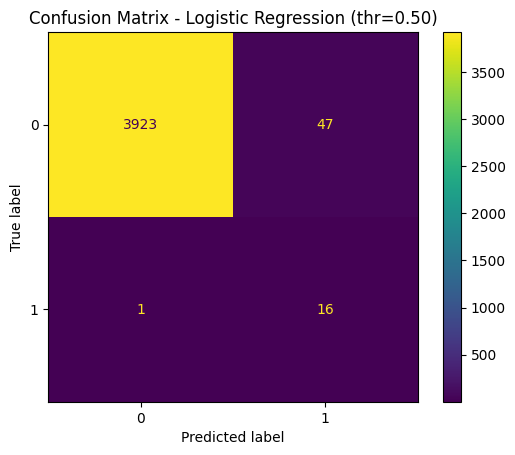

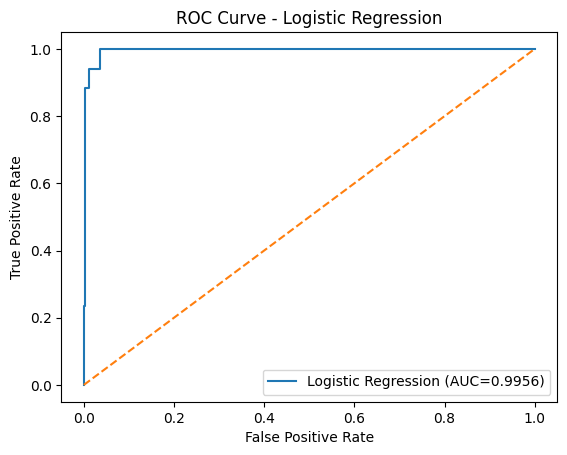

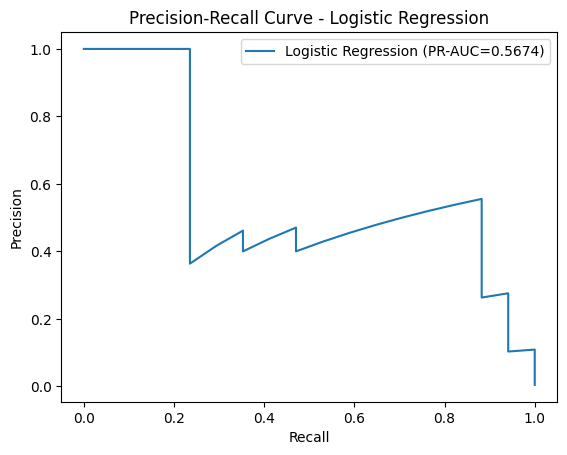


Logistic Regression (threshold=0.99)
Precision (fraud=1): 0.535714
Recall    (fraud=1): 0.882353
F1-score  (fraud=1): 0.666667
ROC-AUC           : 0.995599
PR-AUC (AvgPrec)  : 0.567443

Classification report:
              precision    recall  f1-score   support

           0   0.999495  0.996725  0.998108      3970
           1   0.535714  0.882353  0.666667        17

    accuracy                       0.996238      3987
   macro avg   0.767605  0.939539  0.832387      3987
weighted avg   0.997517  0.996238  0.996695      3987



In [70]:
lr_clf = LogisticRegression(
    max_iter=3000,
    class_weight="balanced",
    n_jobs=None,
    random_state=RANDOM_STATE
)

lr_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("model", lr_clf)
])

lr_pipe.fit(X_train, y_train)

# Probabilitas untuk validation dan test
lr_proba_val = lr_pipe.predict_proba(X_val)[:, 1]
lr_proba_test = lr_pipe.predict_proba(X_test)[:, 1]

# Threshold tuning di validation
lr_best_t, lr_best_f1 = best_threshold_by_f1(y_val, lr_proba_val)
print(f"LR best threshold (by F1 on val): {lr_best_t:.2f} | F1={lr_best_f1:.6f}")

# Evaluasi final di test (default 0.5 dan tuned threshold)
lr_metrics_test_05 = evaluate_binary_classifier("Logistic Regression", y_test, lr_proba_test, threshold=0.5, plot=True)
lr_metrics_test_tuned = evaluate_binary_classifier("Logistic Regression", y_test, lr_proba_test, threshold=lr_best_t, plot=False)


## 9) Model 2 — XGBoost (Advanced)

- `scale_pos_weight = (#neg/#pos)` membantu menangani imbalance.
- Pipeline: preprocessing → model.

XGB best threshold (by F1 on val): 0.09 | F1=1.000000

XGBoost (threshold=0.50)
Precision (fraud=1): 0.789474
Recall    (fraud=1): 0.882353
F1-score  (fraud=1): 0.833333
ROC-AUC           : 0.999704
PR-AUC (AvgPrec)  : 0.957392

Classification report:
              precision    recall  f1-score   support

           0   0.999496  0.998992  0.999244      3970
           1   0.789474  0.882353  0.833333        17

    accuracy                       0.998495      3987
   macro avg   0.894485  0.940673  0.916289      3987
weighted avg   0.998600  0.998495  0.998537      3987



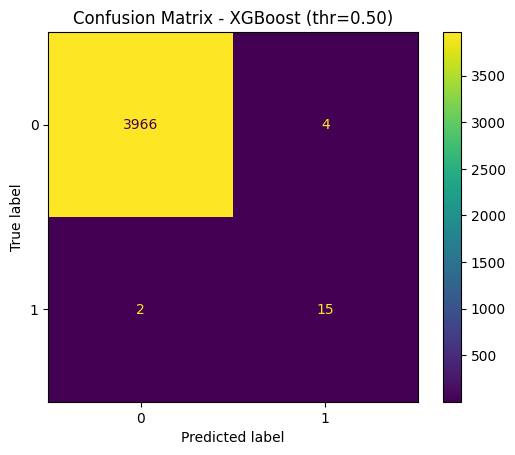

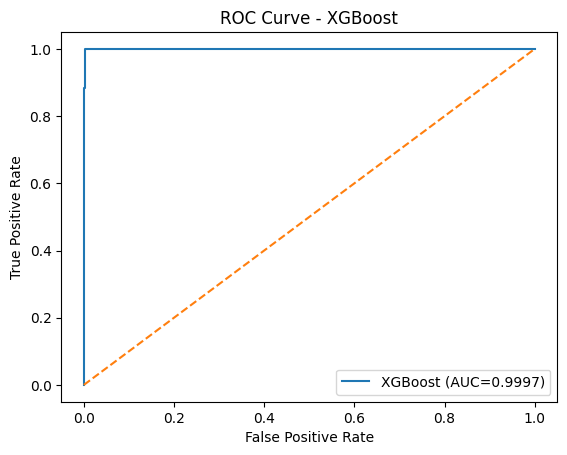

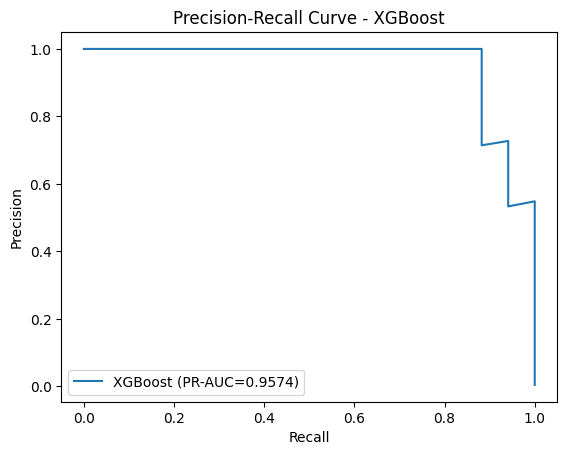


XGBoost (threshold=0.09)
Precision (fraud=1): 0.727273
Recall    (fraud=1): 0.941176
F1-score  (fraud=1): 0.820513
ROC-AUC           : 0.999704
PR-AUC (AvgPrec)  : 0.957392

Classification report:
              precision    recall  f1-score   support

           0   0.999748  0.998489  0.999118      3970
           1   0.727273  0.941176  0.820513        17

    accuracy                       0.998244      3987
   macro avg   0.863510  0.969833  0.909815      3987
weighted avg   0.998586  0.998244  0.998356      3987



In [71]:
if XGBClassifier is None:
    raise RuntimeError("XGBoost tidak tersedia. Install dulu: pip install xgboost")

neg = int((y_train == 0).sum())
pos = int((y_train == 1).sum())
scale_pos_weight = neg / max(pos, 1)

xgb_clf = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight
)

xgb_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("model", xgb_clf)
])

xgb_pipe.fit(X_train, y_train)

xgb_proba_val = xgb_pipe.predict_proba(X_val)[:, 1]
xgb_proba_test = xgb_pipe.predict_proba(X_test)[:, 1]

xgb_best_t, xgb_best_f1 = best_threshold_by_f1(y_val, xgb_proba_val)
print(f"XGB best threshold (by F1 on val): {xgb_best_t:.2f} | F1={xgb_best_f1:.6f}")

xgb_metrics_test_05 = evaluate_binary_classifier("XGBoost", y_test, xgb_proba_test, threshold=0.5, plot=True)
xgb_metrics_test_tuned = evaluate_binary_classifier("XGBoost", y_test, xgb_proba_test, threshold=xgb_best_t, plot=False)


## 10) Perbandingan Model (Test Set)
Tabel berikut membandingkan performa pada **test set**. Baris `Threshold=0.50` menunjukkan performa standar; baris `Threshold=Tuned` menunjukkan performa setelah threshold tuning berdasarkan validation.


,Model,Threshold,Precision,Recall,F1,ROC_AUC,PR_AUC
2,XGBoost,0.50,0.789474,0.882353,0.833333,0.999704,0.957392
3,XGBoost (Tuned),0.09,0.727273,0.941176,0.820513,0.999704,0.957392
1,Logistic Regression (Tuned),0.99,0.535714,0.882353,0.666667,0.995599,0.567443
0,Logistic Regression,0.50,0.253968,0.941176,0.400000,0.995599,0.567443


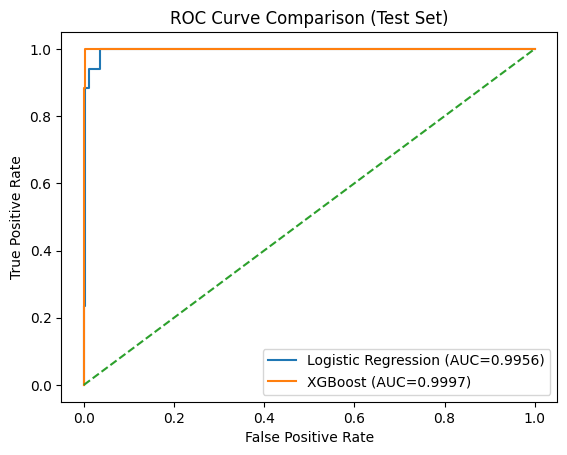

In [72]:
results = pd.DataFrame([
    lr_metrics_test_05,
    {**lr_metrics_test_tuned, "Model": "Logistic Regression (Tuned)"},
    xgb_metrics_test_05,
    {**xgb_metrics_test_tuned, "Model": "XGBoost (Tuned)"},
]).sort_values(by="F1", ascending=False)

display(results)


# ROC Gabungan (Test Set)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_proba_test)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_proba_test)

lr_auc = roc_auc_score(y_test, lr_proba_test)
xgb_auc = roc_auc_score(y_test, xgb_proba_test)

plt.figure()
plt.plot(lr_fpr, lr_tpr, label=f"Logistic Regression (AUC={lr_auc:.4f})")
plt.plot(xgb_fpr, xgb_tpr, label=f"XGBoost (AUC={xgb_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC Curve Comparison (Test Set)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## 11) Pilih Model Terbaik untuk Deployment

Kita pilih model terbaik berdasarkan **F1** pada test set (menggunakan threshold tuned dari validation).

In [73]:
# Pilih berdasarkan F1 tertinggi di antara versi tuned
tuned_rows = results[results["Model"].str.contains("Tuned")]
best_row = tuned_rows.sort_values("F1", ascending=False).iloc[0]

best_name = best_row["Model"]
print("Best model:", best_name)

if "Logistic" in best_name:
    best_model = lr_pipe
    best_threshold = lr_best_t
else:
    best_model = xgb_pipe
    best_threshold = xgb_best_t

print("Best threshold:", best_threshold)


Best model: XGBoost (Tuned)
Best threshold: 0.09


## 12) Interpretasi Model (Untuk Hasil & Pembahasan)

- **XGBoost:** feature importance (Top-k)
- **Logistic Regression:** koefisien (|coef| terbesar)

,feature,importance
12,V11,0.404687
15,V14,0.287316
5,V4,0.118478
4,V3,0.034190
11,V10,0.030425
20,V19,0.022897
13,V12,0.020665
2,V1,0.014453
17,V16,0.009232
10,V9,0.008270


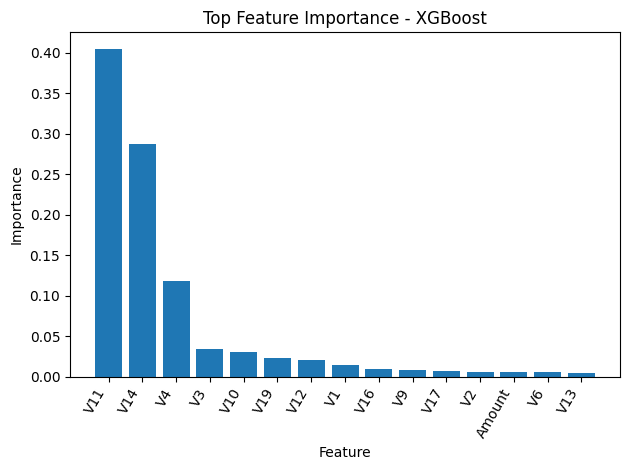

,feature,coef,abs_coef
28,V27,-2.920755,2.920755
5,V4,2.516973,2.516973
26,V25,-2.205706,2.205706
11,V10,-2.192045,2.192045
27,V26,-1.740270,1.740270
20,V19,-1.397440,1.397440
6,V5,-1.108221,1.108221
12,V11,-1.051029,1.051029
25,V24,-1.010198,1.010198
3,V2,-0.953865,0.953865


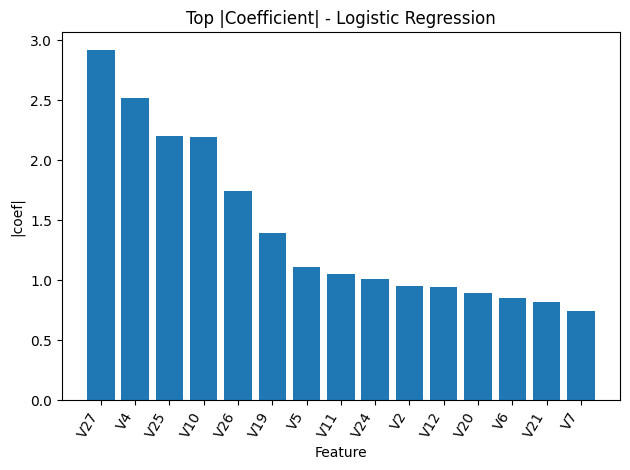

In [74]:
feature_names = preprocess.get_feature_names_out()
topk = 15

# --- Feature importance XGBoost ---
booster = xgb_pipe.named_steps["model"]
importances = booster.feature_importances_
fi = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values("importance", ascending=False)
display(fi.head(topk))

plt.figure()
plt.bar(fi["feature"].head(topk), fi["importance"].head(topk))
plt.title("Top Feature Importance - XGBoost")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.xticks(rotation=60, ha="right")
plt.tight_layout()
plt.show()

# --- Koefisien Logistic Regression ---
lr_model = lr_pipe.named_steps["model"]
coefs = lr_model.coef_.ravel()

coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df = coef_df.sort_values("abs_coef", ascending=False)
display(coef_df.head(topk))

plt.figure()
plt.bar(coef_df["feature"].head(topk), coef_df["abs_coef"].head(topk))
plt.title("Top |Coefficient| - Logistic Regression")
plt.xlabel("Feature")
plt.ylabel("|coef|")
plt.xticks(rotation=60, ha="right")
plt.tight_layout()
plt.show()


## 13) Simpan Model Terbaik (Wajib)

Model disimpan untuk digunakan pada deployment Streamlit.

In [75]:
MODEL_OUT = "fraud_model.joblib"
joblib.dump(best_model, MODEL_OUT)
print("Saved model to:", MODEL_OUT)

THRESH_OUT = "best_threshold.txt"
with open(THRESH_OUT, "w") as f:
    f.write(str(best_threshold))
print("Saved best threshold to:", THRESH_OUT, "=", best_threshold)


Saved model to: fraud_model.joblib
Saved best threshold to: best_threshold.txt = 0.09


## 14) Contoh Prediksi 1 Baris (Simulasi Input Streamlit)

In [76]:
sample = X_test.iloc[[0]].copy()
pred_proba = best_model.predict_proba(sample)[0, 1]
pred_class_default = int(pred_proba >= 0.5)
pred_class_best_t = int(pred_proba >= best_threshold)

print("Sample prediction:")
print("Predicted probability (fraud=1):", float(pred_proba))
print("Predicted class @0.5 threshold :", pred_class_default)
print("Predicted class @best threshold:", pred_class_best_t)


Sample prediction:
Predicted probability (fraud=1): 2.2952708604861982e-05
Predicted class @0.5 threshold : 0
Predicted class @best threshold: 0


## 15) (Opsional) Cross-Validation Stratified — ROC-AUC
Untuk estimasi performa lebih stabil, gunakan CV. Agar tidak berat, gunakan `n_jobs=1` pada CV atau model.


In [77]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Hindari over-parallel saat CV
lr_auc_cv = cross_val_score(lr_pipe, X, y, scoring="roc_auc", cv=cv, n_jobs=1)

# Buat clone pipeline XGB dengan n_jobs=1 untuk CV
xgb_clf_cv = XGBClassifier(**{**xgb_clf.get_params(), "n_jobs": 1})
xgb_pipe_cv = Pipeline(steps=[("prep", preprocess), ("model", xgb_clf_cv)])

xgb_auc_cv = cross_val_score(xgb_pipe_cv, X, y, scoring="roc_auc", cv=cv, n_jobs=1)

print("Cross-validation ROC-AUC:")
print("LR  mean:", lr_auc_cv.mean(), "std:", lr_auc_cv.std())
print("XGB mean:", xgb_auc_cv.mean(), "std:", xgb_auc_cv.std())


Cross-validation ROC-AUC:
LR  mean: 0.974357908850638 std: 0.024674398558034306
XGB mean: 0.9972350578443898 std: 0.004667754047201092
